In [15]:
import numpy as np
import pandas as pd
from scipy.optimize import fsolve, leastsq
import scipy.constants as ct
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [16]:
# Well known constants
Q = ct.physical_constants['atomic unit of charge'][0]
KB = ct.physical_constants['Boltzmann constant'][0]

In [17]:
# Constants for Problem 1
# Saturation Current
I_SAT=1e-9

# Ideality
N=1.7

# Resistance
R_1 = 11000

# Temperature
T_1 = 350

# Voltage
init_voltage = np.arange(0.1, 2.5, 0.1)
step_size = (2.5 - 0.1) / 0.1
V = np.ones(int(step_size + 1))
V

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

In [18]:
# Current through Diode
# Returns the current diode
def Idiode(
    V: float,
    n: float,
    T: int,
    Is: float):
    return Is * (np.exp((Q * V) / (n * KB * T)) - 1)

# Solve for diode voltage
def solve_diode_v(
    prev_v: float,
    src_v: float,
    r_val: int,
    ideality: float,
    temp: int,
    isat_val: float):
    # This is the constant in diode current equation
    vt = (ideality * KB * temp) / Q
    diode_current = isat_val * (np.exp(prev_v / vt) - 1)
    # Solve diode voltage
    return (prev_v - src_v) / r_val + diode_current


In [19]:
diode_voltage = fsolve(solve_diode_v, V, args=(init_voltage, R_1, N, T_1, I_SAT))
diode_voltage

array([0.09993376, 0.19947277, 0.29644374, 0.3813319 , 0.4406315 ,
       0.4776876 , 0.50230459, 0.52012676, 0.53389711, 0.54503839,
       0.55435716, 0.56234689, 0.56932861, 0.57552165, 0.58108195,
       0.58612404, 0.59073435, 0.59497963, 0.59891245, 0.60257491,
       0.6060012 , 0.60921952, 0.61225331, 0.61512231])

In [20]:
diode_current = Idiode(
    V=diode_voltage,
    n=N,
    T=T_1,
    Is=I_SAT)
diode_current

array([6.02199411e-09, 4.79302369e-08, 3.23296545e-07, 1.69710024e-06,
       5.39713543e-06, 1.11193093e-05, 1.79723102e-05, 2.54430214e-05,
       3.32820811e-05, 4.13601465e-05, 4.96038950e-05, 5.79684647e-05,
       6.64246721e-05, 7.49525773e-05, 8.35380046e-05, 9.21705422e-05,
       1.00842332e-04, 1.09547306e-04, 1.18280686e-04, 1.27038645e-04,
       1.35818072e-04, 1.44616407e-04, 1.53431519e-04, 1.62261609e-04])

In [21]:
log_diode_current = np.log10(diode_current)

In [22]:
# Problem 2
# Resistance
R_2 = 10000

# initial ideality
IDEALITY = 1.5

# Initial phi
PHI = 0.8

# temperature
T_2 = 375

# Area
AREA = 1e-8

# Initial voltage
P1_VDD_STEP = 0.1

# Tolerance
THRESHOLD = 1e-6

# MAx iterations
MAX_ITER = 1e6

In [23]:
# Read the contents of diode.txt file
data = pd.read_csv('DiodeIV.txt', header=None, sep=' ')
source_voltages = []
measured_current = []
for V_s, I_d in data.values:
    source_voltages.append(V_s)
    measured_current.append(I_d)
    
source_voltages = np.asarray(source_voltages)
measured_current = np.asarray(measured_current)

In [24]:
measured_current

array([2.61951666e-14, 4.98520829e-13, 9.01503350e-12, 1.62575648e-10,
       2.93116164e-09, 5.27643468e-08, 9.24216059e-07, 1.16604869e-05,
       5.30593614e-05, 1.16395730e-04, 1.88807835e-04, 2.65513449e-04,
       3.44628461e-04, 4.25263629e-04, 5.06938002e-04, 5.89364737e-04,
       6.72359975e-04, 7.55799206e-04, 8.39594390e-04, 9.23681080e-04,
       1.00801073e-03, 1.09254591e-03, 1.17725713e-03, 1.26212080e-03,
       1.34711774e-03, 1.43223215e-03, 1.51745087e-03, 1.60276282e-03,
       1.68815858e-03, 1.77363010e-03, 1.85917040e-03, 1.94477346e-03,
       2.03043397e-03, 2.11614729e-03, 2.20190932e-03, 2.28771641e-03,
       2.37356529e-03, 2.45945306e-03, 2.54537708e-03, 2.63133500e-03,
       2.71732468e-03, 2.80334416e-03, 2.88939166e-03, 2.97546558e-03,
       3.06156443e-03, 3.14768684e-03, 3.23383156e-03, 3.31999743e-03,
       3.40618338e-03, 3.49238842e-03])

In [25]:
def solve_current_diode(
    A: float, 
    phi: float,
    R: float,
    n: float, 
    temp: float,
    v_s: np.array):
    
    # create zero array to store computed diode current/voltage
    diode_voltage_est = np.zeros_like(v_s)
    current_diode = np.zeros_like(v_s)
    # specify initial diode voltage for fsolve()
    v_guess = P1_VDD_STEP
    is_val = A * temp * temp * np.exp(-phi * Q / ( KB * temp ) )
    
    # for every given source voltage, calculate diode voltage by solving nodal analysis
    for index in range(len(v_s)):
        v_guess = fsolve(solve_diode_v, v_guess, (v_s[index], R, n, temp, is_val),
                                xtol = 1e-12)[0]
        diode_voltage_est[index] = v_guess    
    # compute the diode current
    vt = (n * KB * temp) / Q  # calc constant for diode current equation
    current_diode = is_val * (np.exp(diode_voltage_est / vt) - 1) # calc diode current by its definition
    return current_diode

def opt_r(R_guess: float, 
          phi_guess: float,
          n_guess: float,
          A: float,
          T: int,
          v_src: np.array,
          current_meas: np.array):  
    # diode current is obtained using optimized parameters
    current_diode = solve_current_diode(A, phi_guess, R_guess, n_guess, T, v_src)
    # Absolute error
    return (current_diode - measured_current)

    
def opt_phi(phi_guess: float,
            R_guess: float,
            n_guess: float,
            A: float,
            T: int,
            v_src: np.array,
            current_meas: np.array):
    # diode current is obtained using optimized parameters
    current_diode = solve_current_diode(A, phi_guess, R_guess, n_guess, T, v_src)
    # Normalized error is obtained by adding a contant in denominator for handling 0/0 case
    return (current_diode - measured_current) / (current_diode + measured_current + 1e-15)
    
def opt_n(n_guess: float,
          R_guess: float,
          phi_guess: float,
          A: float,
          T: int,
          v_src: np.array,
          current_meas: np.array):
    # diode current is obtained using optimized parameters
    current_diode = solve_current_diode(A, phi_guess, R_guess, n_guess, T, v_src)
    # Normalized error is obtained by adding a contant in denominator for handling 0/0 case
    return (current_diode - measured_current) / (current_diode + measured_current + 1e-15)

In [26]:
err = 10
iteration = 1
r_val = R_2
n_val = IDEALITY
phi_val = PHI
current_pred = None
while err > THRESHOLD and iteration < MAX_ITER:
    r_val_opt = leastsq(opt_r, r_val, args=(phi_val, n_val, AREA, T_2, source_voltages, measured_current))
    r_val = r_val_opt[0][0]
    
    n_val_opt = leastsq(opt_n, n_val, args=(r_val, phi_val, AREA, T_2, source_voltages, measured_current))
    n_val = n_val_opt[0][0]
    
    phi_val_opt = leastsq(opt_phi, phi_val, args=(r_val, n_val, AREA, T_2, source_voltages, measured_current))
    phi_val = phi_val_opt[0][0]
    
    current_pred = solve_current_diode(AREA, phi_val, r_val, n_val, T_2, source_voltages)
    # calc error values array for optimizing result check
    err = np.linalg.norm((current_pred - measured_current) / (current_pred + measured_current + 1e-15), ord = 1)
    
    # Print iteration progress
    if iteration % 1 == 0:
        print(f"Iter#: {iteration} ; phi: {phi_val} ; n: {n_val} ; R: {r_val} ; Residual Error: {err}")

    # Increment the iteration count
    iteration += 1

Iter#: 1 ; phi: 0.8174791942071215 ; n: 1.2728042885994006 ; R: 1045.5784329638605 ; Residual Error: 4.877172272292447
Iter#: 2 ; phi: 0.8321575606849234 ; n: 1.230288846837419 ; R: 1111.8860890601704 ; Residual Error: 3.7535064735956496
Iter#: 3 ; phi: 0.8439398773312575 ; n: 1.196998866473622 ; R: 1119.0729096024172 ; Residual Error: 3.0889323384116216
Iter#: 4 ; phi: 0.8533130284228546 ; n: 1.1704613962997683 ; R: 1124.93670196316 ; Residual Error: 2.508946586229388
Iter#: 5 ; phi: 0.8607600859079024 ; n: 1.14949826632866 ; R: 1129.867404913945 ; Residual Error: 2.0225876745644396
Iter#: 6 ; phi: 0.8666832027197167 ; n: 1.1329747259258907 ; R: 1133.8975050376112 ; Residual Error: 1.6233485009183937
Iter#: 7 ; phi: 0.871400520868461 ; n: 1.1199412788302683 ; R: 1137.146739115907 ; Residual Error: 1.2994833542161834
Iter#: 8 ; phi: 0.8751613547993244 ; n: 1.1096448753907961 ; R: 1139.7500267766638 ; Residual Error: 1.0385631212026747
Iter#: 9 ; phi: 0.8781615288929288 ; n: 1.101497469

Iter#: 70 ; phi: 0.8900006256252576 ; n: 1.0699992643018654 ; R: 1149.9999920083956 ; Residual Error: 8.150067305750513e-07


In [27]:
print("\n\n==========\n")
print(f"Took {iteration} iterations to complete...")
print(f"ESTIMATED RESISTANCE (R) : {r_val}")
print(f"ESTIMATED Phi : {phi_val}")
print(f"ESTIMATED Ideality factor (n) : {n_val}")




Took 71 iterations to complete...
ESTIMATED RESISTANCE (R) : 1149.9999920083956
ESTIMATED Phi : 0.8900006256252576
ESTIMATED Ideality factor (n) : 1.0699992643018654


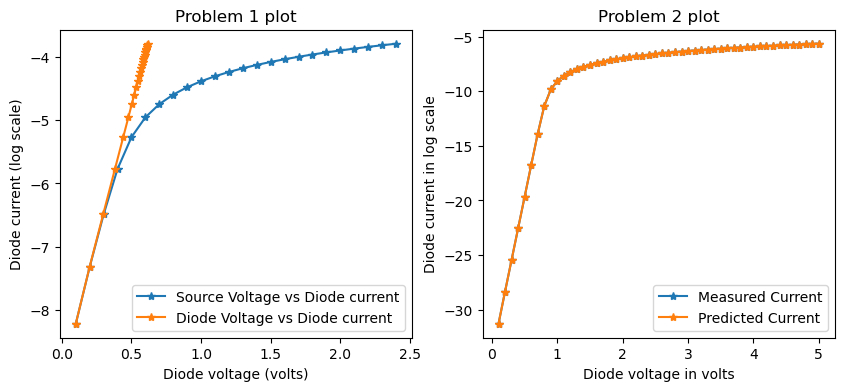

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
# Problem 1 graph
ax1.plot(init_voltage, log_diode_current, label="Source Voltage vs Diode current", marker="*")
ax1.plot(diode_voltage, log_diode_current, label="Diode Voltage vs Diode current", marker="*")
ax1.set_ylabel("Diode current (log scale)")
ax1.set_xlabel("Diode voltage (volts)")
ax1.set_title("Problem 1 plot")
ax1.legend()

# Set axes params for the plot
ax2.set_xlabel("Diode voltage in volts")
ax2.set_ylabel("Diode current in log scale")
ax2.set_title("Problem 2 plot")

# Plot the given values of Source voltage and diode current in DiodeIV.txt (Actual values)
ax2.plot(source_voltages, np.log(measured_current), label="Measured Current", marker='*')

# Plot the given values of diode current and diode voltage in DiodeIV.txt (Predicted values)
ax2.plot(source_voltages, np.log(current_pred), label="Predicted Current", marker='*')
ax2.legend()
plt.show()